In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
train_data_dir = '/content/drive/My Drive/Alzheimer_s Dataset/train'
validation_data_dir = '/content/drive/My Drive/Alzheimer_s Dataset/validation'

In [8]:
!pip install tensorflow-addons


In [10]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [11]:
# Update the path to your Testing folder in Google Drive
test_data_dir = '/content/drive/My Drive/Alzheimer_s Dataset/test'

filepaths = []
labels = []
folds = os.listdir(test_data_dir)

for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
dt = pd.concat([Fseries, Lseries], axis='columns')

# Display the data frame
dt

,filepaths,labels
0,/content/drive/My Drive/Alzheimer_s Dataset/te...,ModerateDemented
1,/content/drive/My Drive/Alzheimer_s Dataset/te...,ModerateDemented
2,/content/drive/My Drive/Alzheimer_s Dataset/te...,ModerateDemented
3,/content/drive/My Drive/Alzheimer_s Dataset/te...,ModerateDemented
4,/content/drive/My Drive/Alzheimer_s Dataset/te...,ModerateDemented
...,...,...
1274,/content/drive/My Drive/Alzheimer_s Dataset/te...,NonDemented
1275,/content/drive/My Drive/Alzheimer_s Dataset/te...,NonDemented
1276,/content/drive/My Drive/Alzheimer_s Dataset/te...,NonDemented
1277,/content/drive/My Drive/Alzheimer_s Dataset/te...,NonDemented


In [12]:
train_data_dir = '/content/Training'
filepaths = []
labels = []
train_data_dir = '/content/drive/My Drive/Alzheimer_s Dataset/train'

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data = pd.concat([Fseries, Lseries], axis= 1)
data



,filepaths,labels
0,/content/drive/My Drive/Alzheimer_s Dataset/tr...,MildDemented
1,/content/drive/My Drive/Alzheimer_s Dataset/tr...,MildDemented
2,/content/drive/My Drive/Alzheimer_s Dataset/tr...,MildDemented
3,/content/drive/My Drive/Alzheimer_s Dataset/tr...,MildDemented
4,/content/drive/My Drive/Alzheimer_s Dataset/tr...,MildDemented
...,...,...
5116,/content/drive/My Drive/Alzheimer_s Dataset/tr...,ModerateDemented
5117,/content/drive/My Drive/Alzheimer_s Dataset/tr...,ModerateDemented
5118,/content/drive/My Drive/Alzheimer_s Dataset/tr...,ModerateDemented
5119,/content/drive/My Drive/Alzheimer_s Dataset/tr...,ModerateDemented


In [13]:
valid_df,test_df = train_test_split(dt,train_size=0.5,shuffle=True,random_state=123)

In [14]:
batch_size=16
img_size = (224,224)
channels = 3
img_shape=(img_size[0],img_size[1],channels)  #224*224*3
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( data, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)
test_gen = tr_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= False ,batch_size= batch_size)
valid_gen = tr_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels',
                                         target_size= img_size, class_mode= 'categorical', color_mode= 'rgb', shuffle= True,batch_size= batch_size)

Found 5121 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.
Found 639 validated image filenames belonging to 4 classes.


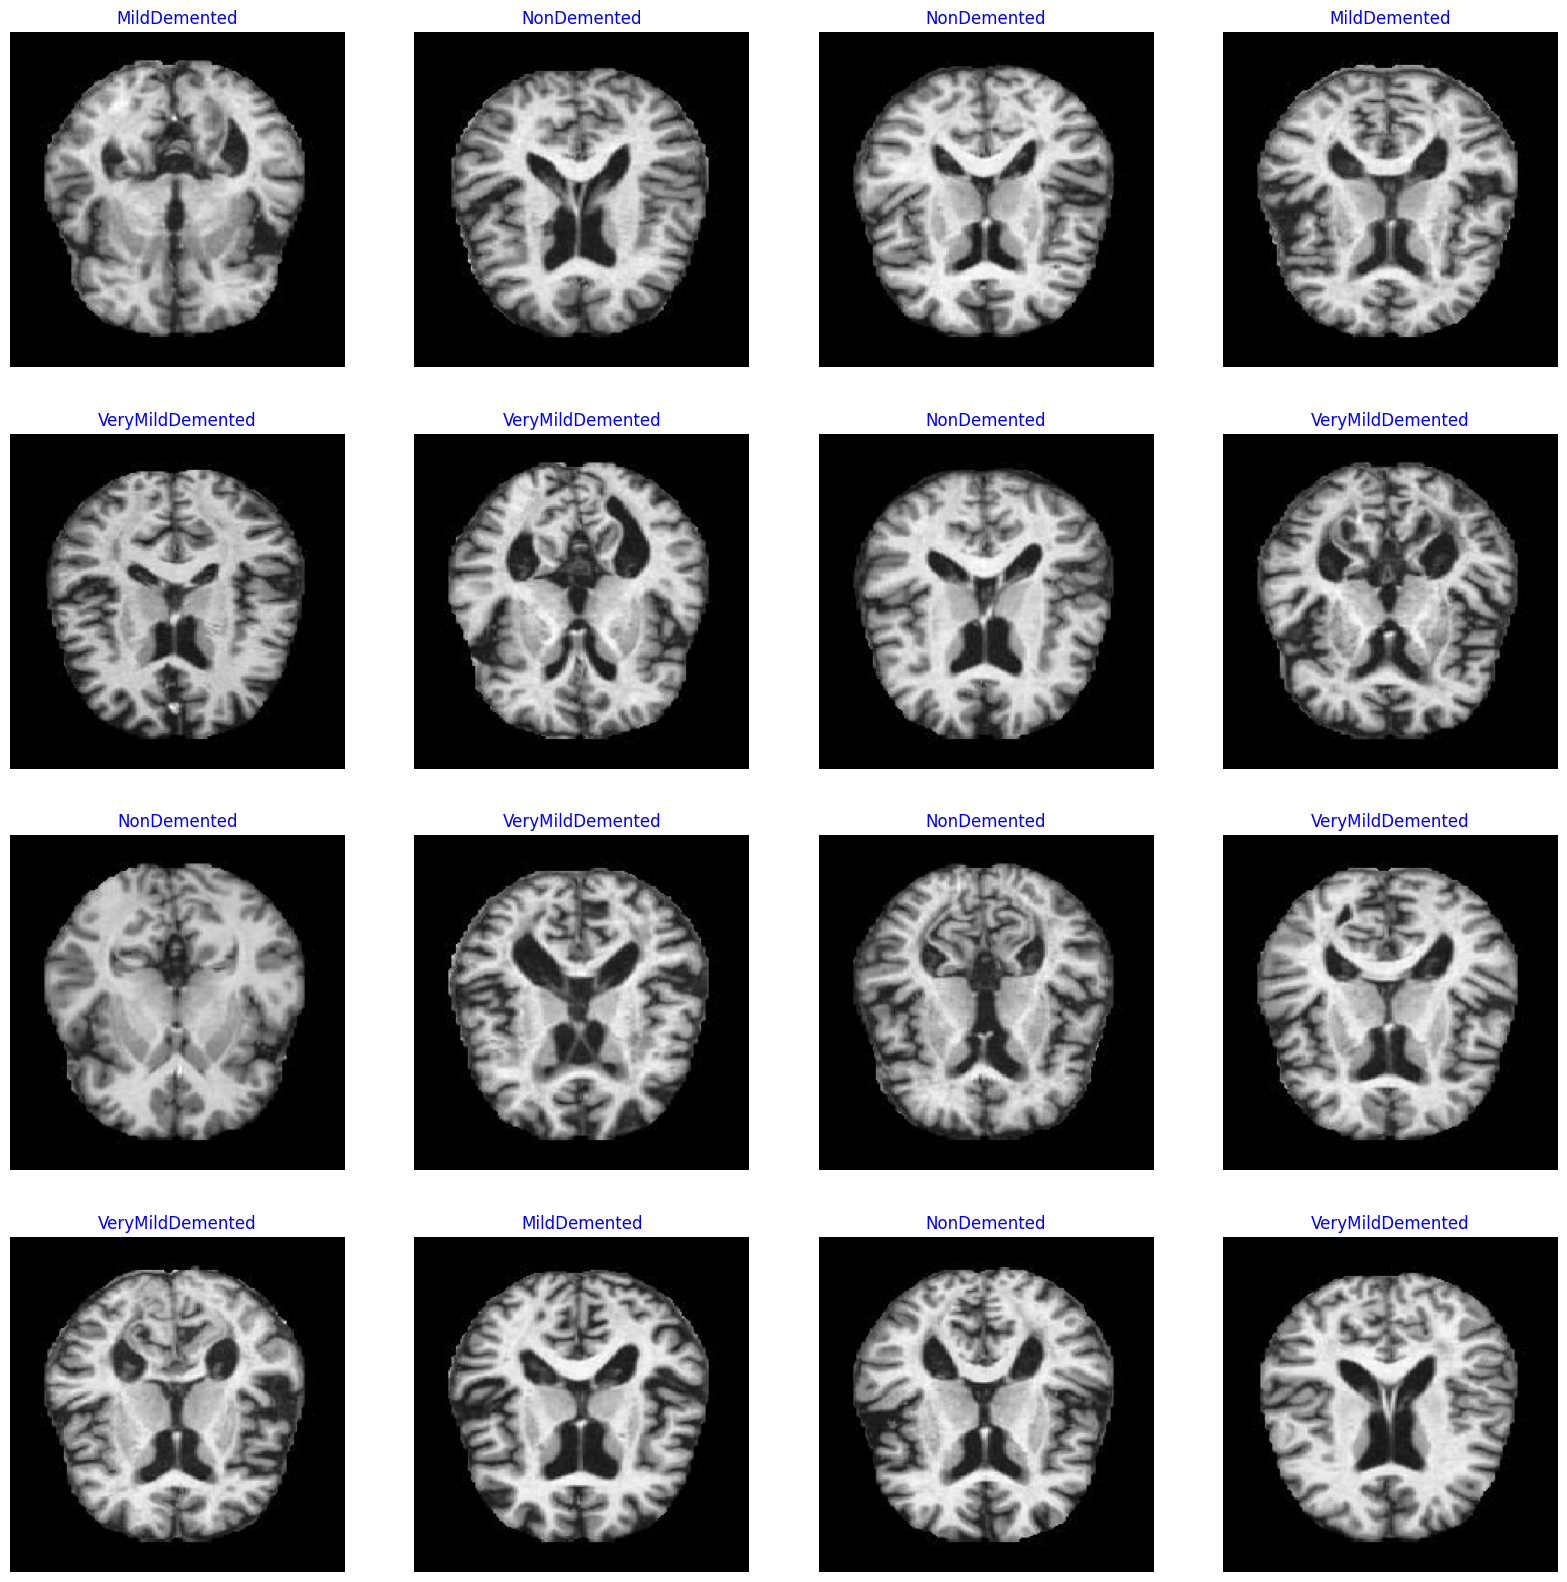

In [15]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images,labels = next(train_gen)
plt.figure(figsize = (20,20))
for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i]/255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name= classes[index]
    plt.title(class_name,color='blue',fontsize=12)
    plt.axis('off')
plt.show();

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # if you have validation data
)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Alzheimer_s Dataset/train',
    target_size=(224, 224),  # adjust as per your model requirements
    batch_size=32,
    class_mode='categorical',  # adjust based on your task
    subset='training'  # for training data
)


Found 4098 images belonging to 4 classes.


In [17]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Define the VGG19 model
base_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet",
                                         input_shape=img_shape, pooling='max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2( 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()
Model: "sequential_1"

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20158788 (76.90 MB)
Trainable params: 20157

In [18]:
valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # same split ratio as training data
)

valid_gen = valid_datagen.flow_from_directory(
    '/content/drive/My Drive/Alzheimer_s Dataset/train',  # use the same directory as for training
    target_size=(224, 224),  # adjust based on your model requirements
    batch_size=32,
    class_mode='categorical',  # adjust based on your task
    subset='validation'  # for validation data
)


Found 1023 images belonging to 4 classes.


In [19]:
epochs = 20
history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/20
129/129 [==============================] - 901s 7s/step - loss: 5.1380 - accuracy: 0.5098 - val_loss: 7.3691 - val_accuracy: 0.5797
Epoch 2/20
129/129 [==============================] - 88s 679ms/step - loss: 3.3546 - accuracy: 0.5705 - val_loss: 5.4539 - val_accuracy: 0.3392
Epoch 3/20
129/129 [==============================] - 89s 690ms/step - loss: 2.6076 - accuracy: 0.5842 - val_loss: 4.9007 - val_accuracy: 0.5005
Epoch 4/20
129/129 [==============================] - 89s 688ms/step - loss: 2.1687 - accuracy: 0.5893 - val_loss: 2.7204 - val_accuracy: 0.5161
Epoch 5/20
129/129 [==============================] - 90s 696ms/step - loss: 1.8762 - accuracy: 0.5920 - val_loss: 5.1904 - val_accuracy: 0.5005
Epoch 6/20
129/129 [==============================] - 91s 699ms/step - loss: 1.6705 - accuracy: 0.5966 - val_loss: 4.9921 - val_accuracy: 0.1398
Epoch 7/20
129/129 [==============================] - 91s 700ms/step - loss: 1.5291 - accuracy: 0.5849 - val_loss: 2.2702 - val_accu

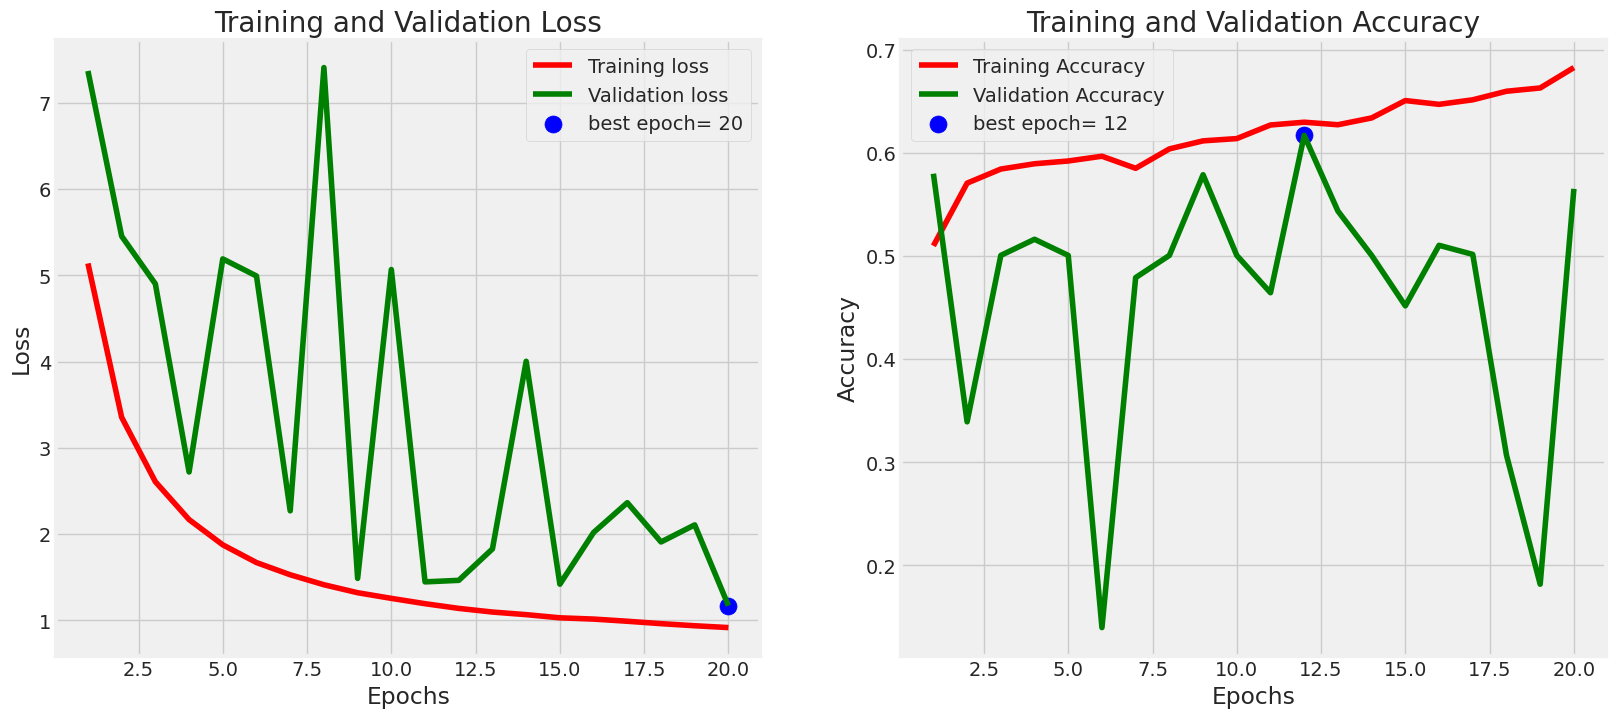

In [20]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [21]:
# Evaluate the model
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

# Predict and generate confusion matrix
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
g_dict = test_gen.class_indices
classes = list(g_dict.keys())
cm = confusion_matrix(test_gen.classes, y_pred)
cm

40/40 [==============================] - 3s 78ms/step


array([[ 73,   0,  25,   0],
       [  5,   0,   1,   0],
       [227,   0,  89,   0],
       [149,   0,  71,   0]])

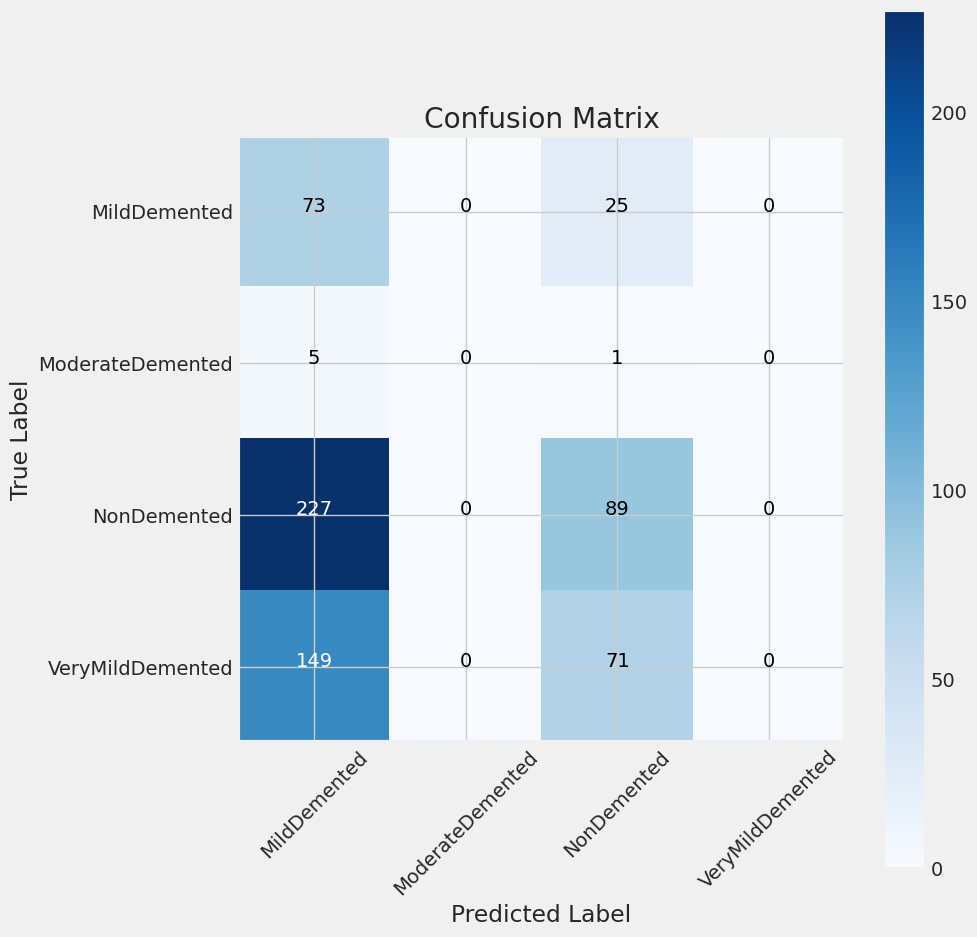

Accuracy: 0.2531
Precision: 0.2609
Recall: 0.2531
F1 Score: 0.2156


In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Added part to print classification report and accuracy
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score


# Compute and print accuracy, precision, recall, F1-score
accuracy = accuracy_score(test_gen.classes, y_pred)
precision = precision_score(test_gen.classes, y_pred, average='weighted')
recall = recall_score(test_gen.classes, y_pred, average='weighted')
f1 = f1_score(test_gen.classes, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [23]:
import os

# Define the path where you want to save the model in Google Drive
model_save_path = '/content/drive/My Drive/Alzheimer_s Dataset/model.h5'

# Save the model
model.save(model_save_path)


In [24]:
# Load the saved model
loaded_model = tf.keras.models.load_model(model_save_path)

# Check model summary
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20158788 (76.90 MB)
Trainable params: 20157764 (76.90 MB)
Non-trainable params: 1024 (4.00 KB)
_____________